In [1]:
from trendAnalyserPy import StockTrendAnalyzer
from backtestPy import Backtester
from optimizerPy import Optimizer
from stockData import StockData
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
class Trading:
    def __init__(self, symbol, start_date, end_date, interval, specific_given_date=None, period=None):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.period = period
        self.stock_intraday = None

        # Initialize the detector with properly loaded data
        self._load_data(specific_given_date, period)
        self.detector = StockTrendAnalyzer(symbol, start_date, end_date, self.stock, interval)
        self.backtester = Backtester(symbol, start_date, end_date, interval, self.stock)
        self.optimizer = Optimizer(self.backtester)

        self.peaks = []
        self.throughs = []
        self.uptrends = []
        self.downtrends = []
        self.peaks_intraday = []
        self.troughs_intraday = []
        self.uptrends_intraday = []
        self.downtrends_intraday = []
        

    def _load_data(self, specific_given_date, period):
        """
        Load stock data, considering intraday intervals with period and start_date.
        """
        self.load_data = StockData(symbol, start_date, end_date, interval, specific_given_date, period)
        if self.interval in ['1m', '2m', '5m', '15m', '30m', '60m', '90m']: 
            self.stock, self.stock_intraday = self.load_data.load_intraday_data()
        else:
            self.stock = self.load_data.load_daily_data()

    def analyze_stock(self):
        """
        Analyze stock trends for the initialized symbol and time period.
        """
        analyzer = self.detector
        analyzer.data = self.stock  # Ensure detector works with the loaded data
        self.peaks, self.troughs = analyzer.find_peaks_and_troughs()
        self.uptrends, self.downtrends = analyzer.identify_trends()

        # Print trend summary
        print(f"\nTrend Summary for {self.symbol}:")
        for summary in analyzer.get_trend_summary():
            print(summary)

        # Generate visualization
        if self.stock_intraday is None:
            plt = analyzer.visualize_trends()
            plt.show()

        if self.stock_intraday is not None and len(self.stock_intraday) > 0:
            analyzer.data = self.stock_intraday
            self.peaks_intraday, self.troughs_intraday = analyzer.find_peaks_and_troughs()
            self.uptrends_intraday, self.downtrends_intraday = analyzer.identify_trends()
            last_peak_idx = self.peaks[-1]
            last_trough_idx = self.troughs[-1]
            last_daily_peak = self.stock.iloc[last_peak_idx]['High']
            last_daily_trough = self.stock.iloc[last_trough_idx]['Low']
            #analyzer.visualize_intraday_trends(self.stock.iloc[-1], last_daily_peak, last_daily_trough)
            
 
        return analyzer

    def analyze_and_backtest(self, strategy=None, **kwargs):
        """
        Perform analysis to find peaks and troughs, and then backtest using the results.
        """
        # Step 1: Analyze data to find peaks and troughs
        peaks = self.peaks
        troughs = self.troughs
        uptrends = self.uptrends
        downtrends = self.downtrends
    
        # Step 2: Update params with peaks and troughs
        params = {}
        params["peaks"] = peaks
        params["troughs"] = troughs
        params["uptrends"] = uptrends
        params["downtrends"] = downtrends
    
        # Step 3: Initialize Backtester with data and params
        backtester = Backtester(
            symbol=self.symbol,
            start_date=self.start_date,
            end_date=self.end_date,
            interval=self.interval,
            data=self.stock,
            initial_capital=10000,
            strategy=strategy,
            **params
        )
    
        # Step 4: Run the backtest and return results
        results = backtester.backtest(strategy, **kwargs)
        plt = backtester.visualize_data()
        plt.show()
        if results is not None:
            backtester.print_results(results)
        return backtester

    def backtest_intraday(self, analyzer, strategy=None, **kwargs):
        params = {}
        params["peaks"] = self.peaks
        params["troughs"] = self.troughs
        params["uptrends"] = self.uptrends
        params["downtrends"] = self.downtrends
        params["peaks_intraday"] = self.peaks_intraday
        params["troughs_intraday"] = self.troughs_intraday
        params["uptrends_intraday"] = self.uptrends_intraday
        params["downtrends_intraday"] = self.downtrends_intraday
        params["daily_data"] = self.stock

        start_date = self.stock_intraday.index[0].strftime("%Y-%m-%d")
        end_date = self.stock_intraday.index[-1].strftime("%Y-%m-%d")

        backtester = Backtester(
            symbol=self.symbol,
            start_date=start_date,
            end_date=end_date,
            interval=self.interval,
            data=self.stock_intraday,
            initial_capital=10000,
            strategy=strategy,
            **params
        )
        results = backtester.backtest(strategy, **kwargs)

        if results is not None:
            last_peak_idx = self.peaks[-1]
            last_trough_idx = self.troughs[-1]
            last_daily_peak = self.stock.iloc[last_peak_idx]['High']
            last_daily_trough = self.stock.iloc[last_trough_idx]['Low']
            backtester.print_results(results)
            if self.period:
                backtester.get_trades_info_per_day()
            backtester.visualize_intraday_data(self.stock.iloc[-1],last_daily_peak, last_daily_trough)
        return backtester
        
    def optimize(self, strategy, param_ranges, initial_guess):
        """
        Optimize trading strategy parameters.
        """
        backtester = Backtester(self.stock)
        optimizer = Optimizer(backtester)
        return optimizer.optimize(strategy, param_ranges, initial_guess)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Trend Summary for SPY:
Uptrend: Start: 2023-11-28 (Price: $454.93), End: 2024-01-04 (Price: $467.28), Change: 2.7%
Uptrend: Start: 2024-01-17 (Price: $472.29), End: 2024-04-04 (Price: $513.07), Change: 8.6%
Uptrend: Start: 2024-05-02 (Price: $505.03), End: 2024-05-23 (Price: $525.96), Change: 4.1%
Uptrend: Start: 2024-06-25 (Price: $544.83), End: 2024-07-24 (Price: $541.23), Change: -0.7%
Uptrend: Start: 2024-08-28 (Price: $558.30), End: 2024-09-03 (Price: $552.08), Change: -1.1%
Uptrend: Start: 2024-09-20 (Price: $568.25), End: 2024-10-31 (Price: $568.64), Change: 0.1%
Downtrend: Start: 2024-04-04 (Price: $513.07), End: 2024-04-26 (Price: $508.26), Change: -0.9%
Downtrend: Start: 2024-08-01 (Price: $543.01), End: 2024-08-19 (Price: $559.61), Change: 3.1%

BACKTEST RESULTS
Symbol:                  SPY			Buy & Hold Net Profit:   $ -230.43
Start Date:              2024-11-11		Buy & Hold Profit:     -2.3%
End Date:                2024-11-15
-----------------------------------------------

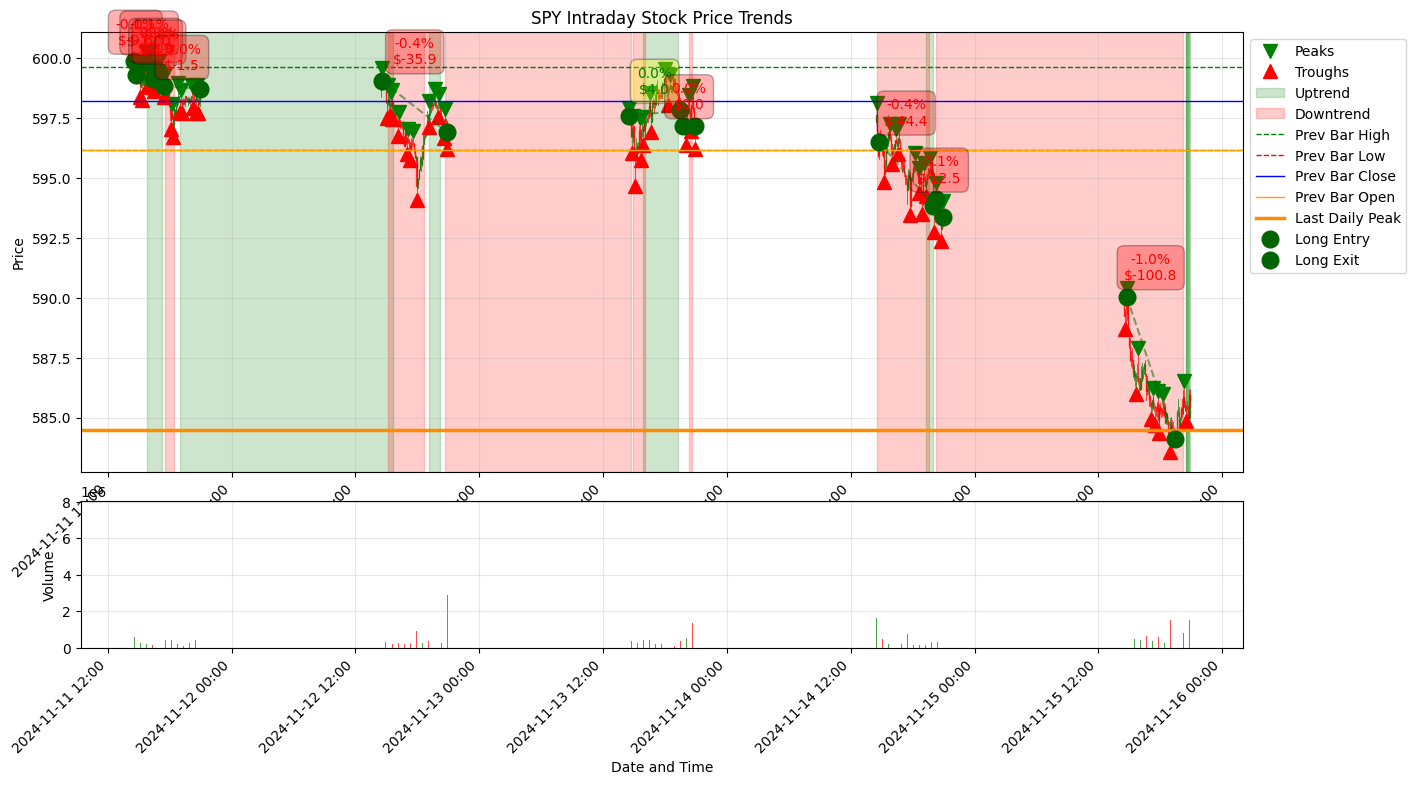

In [4]:
symbol='SPY'
start_date='2024-11-21' 
end_date='2024-03-11'
interval='5m'
period='5d'
specific_given_date='2024-11-11'
trading = Trading(symbol, start_date, end_date, interval=interval, specific_given_date=specific_given_date, period=period)
analyzer = trading.analyze_stock()
#backtest = trading.analyze_and_backtest()
backtest = trading.backtest_intraday(analyzer,strategy=multi_indicator_strategy, ema_fast=12,
    ema_slow=26,
    rsi_period=14,
    rsi_oversold=30,
    rsi_overbought=70,
    macd_fast=12,
    macd_slow=26,
    macd_signal=9,
    bb_period=20,
    bb_std=2)

In [5]:
backtest.get_trades_info_per_day()


Daily Trading Statistics
      Date Entry Price Exit Price Profit ($) Profit (%)  Trades Count Price Change ($) Price Change (%)
2024-11-11     $599.86    $598.72    $-27.67     -0.06%             5           $-1.14           -0.19%
2024-11-12     $599.04    $596.89    $-35.89     -0.36%             1           $-2.15           -0.36%
2024-11-13     $597.57    $597.17      $4.02      0.02%             2           $-0.40           -0.07%
2024-11-14     $596.49    $593.37    $-56.88     -0.28%             2           $-3.12           -0.52%
2024-11-15     $590.04    $584.09   $-100.84     -1.01%             1           $-5.95           -1.01%


,close_date,entry_price,exit_price,profit_money,profit_percent,type,price_change_money,price_change_percent
0,2024-11-11,599.859985,598.719971,-27.666483,-0.055333,5,-1.140015,-0.190047
1,2024-11-12,599.039978,596.890015,-35.890149,-0.358901,1,-2.149963,-0.358901
2,2024-11-13,597.570007,597.169983,4.016102,0.020081,2,-0.400024,-0.066942
3,2024-11-14,596.489990,593.369995,-56.881391,-0.284407,2,-3.119995,-0.523059
4,2024-11-15,590.039917,584.090027,-100.838773,-1.008388,1,-5.949890,-1.008388


In [3]:
def sma_crossover_strategy(data: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    Simple Moving Average (SMA) crossover strategy for long positions only.
    Generates buy signals when short-term SMA crosses above long-term SMA,
    and exit signals when short-term SMA crosses below long-term SMA.
    
    Args:
        data (pd.DataFrame): DataFrame with OHLCV data
        **kwargs: Strategy parameters including:
            - sma_s (int): Short-term SMA period (default: 20)
            - sma_l (int): Long-term SMA period (default: 50)
            - take_profit (float): Take profit percentage (default: None)
            - stop_loss (float): Stop loss percentage (default: None)
    
    Returns:
        pd.DataFrame: DataFrame with Position column (0 for no position, 1 for long)
    """
    # Get parameters from kwargs with defaults
    sma_s = kwargs.get('sma_s', 20)
    sma_l = kwargs.get('sma_l', 50)
    
    # Calculate SMAs
    data['SMA_Short'] = data['Close'].rolling(window=sma_s).mean()
    data['SMA_Long'] = data['Close'].rolling(window=sma_l).mean()
    
    # Initialize position column
    data['Position'] = 0
    
    # Generate signals
    # Long entry signal: Short SMA crosses above Long SMA
    data.loc[data['SMA_Short'] > data['SMA_Long'], 'Position'] = 1
    
    # Exit signal: Short SMA crosses below Long SMA
    data.loc[data['SMA_Short'] < data['SMA_Long'], 'Position'] = 0
    
    # Fill NaN values with 0
    data['Position'] = data['Position'].fillna(0)
    
    # Return DataFrame with Position column
    return data[['Position']]

# Add name attribute for strategy identification
sma_crossover_strategy._name_ = 'Long_Only_SMA_Crossover'

In [3]:
def multi_indicator_strategy(data: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    Strategy using 5 technical indicators with fixed 1% stop loss.
    Exits when any 2 indicators show sell signals or at the end of the day.
    """
    # Get indicator parameters (unchanged)
    ema_fast = kwargs.get('ema_fast', 12)
    ema_slow = kwargs.get('ema_slow', 26)
    rsi_period = kwargs.get('rsi_period', 14)
    rsi_oversold = kwargs.get('rsi_oversold', 30)
    rsi_overbought = kwargs.get('rsi_overbought', 70)
    macd_fast = kwargs.get('macd_fast', 12)
    macd_slow = kwargs.get('macd_slow', 26)
    macd_signal = kwargs.get('macd_signal', 9)
    bb_period = kwargs.get('bb_period', 20)
    bb_std = kwargs.get('bb_std', 2)
    
    # Calculate indicators (unchanged)
    data['EMA_Fast'] = data['Close'].ewm(span=ema_fast, adjust=False).mean()
    data['EMA_Slow'] = data['Close'].ewm(span=ema_slow, adjust=False).mean()
    
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    exp1 = data['Close'].ewm(span=macd_fast, adjust=False).mean()
    exp2 = data['Close'].ewm(span=macd_slow, adjust=False).mean()
    data['MACD'] = exp1 - exp2
    data['Signal_Line'] = data['MACD'].ewm(span=macd_signal, adjust=False).mean()
    data['MACD_Hist'] = data['MACD'] - data['Signal_Line']
    
    data['BB_Middle'] = data['Close'].rolling(window=bb_period).mean()
    bb_std_dev = data['Close'].rolling(window=bb_period).std()
    data['BB_Upper'] = data['BB_Middle'] + (bb_std * bb_std_dev)
    data['BB_Lower'] = data['BB_Middle'] - (bb_std * bb_std_dev)
    
    data['Cumulative_Volume'] = data['Volume'].cumsum()
    data['Cumulative_PV'] = (data['Close'] * data['Volume']).cumsum()
    data['VWAP'] = data['Cumulative_PV'] / data['Cumulative_Volume']
    
    # Initialize position tracking
    data['Position'] = 0
    data['Entry_Price'] = 0
    data['Entry_Price'] = data['Entry_Price'].astype('float64')
    data['Stop_Loss'] = 0
    data['Stop_Loss'] = data['Stop_Loss'].astype('float64')

    position_open = False
    entry_price = 0
    stop_loss = 0
    
    for i in range(1, len(data)):
        current_close = data['Close'].iloc[i]
        
        # Detect end of day
        current_date = data.index[i].date()
        next_date = data.index[i + 1].date() if i + 1 < len(data) else None
        end_of_day = next_date and current_date != next_date
        
        if position_open:
            # Check stop loss first
            if current_close <= stop_loss:
                position_open = False
                data.loc[data.index[i], 'Position'] = 0
                continue
            
            # Count sell signals from indicators
            sell_signals = 0
            
            # EMA sell signal
            if (data['EMA_Fast'].iloc[i] < data['EMA_Slow'].iloc[i] and 
                data['EMA_Fast'].iloc[i-1] >= data['EMA_Slow'].iloc[i-1]):
                sell_signals += 1
            
            # RSI sell signal
            if (data['RSI'].iloc[i] > rsi_overbought and 
                data['RSI'].iloc[i-1] <= rsi_overbought):
                sell_signals += 1
            
            # MACD sell signal
            if (data['MACD_Hist'].iloc[i] < 0 and 
                data['MACD_Hist'].iloc[i-1] >= 0):
                sell_signals += 1
            
            # Bollinger Bands sell signal
            if (data['Close'].iloc[i-1] >= data['BB_Upper'].iloc[i-1] and 
                data['Close'].iloc[i] < data['BB_Upper'].iloc[i]):
                sell_signals += 1
            
            # VWAP sell signal
            if (data['Close'].iloc[i] < data['VWAP'].iloc[i] and 
                data['Close'].iloc[i-1] >= data['VWAP'].iloc[i-1]):
                sell_signals += 1
            
            # Exit if 2 or more sell signals or at end of day
            if sell_signals >= 2 or end_of_day:
                position_open = False
                data.loc[data.index[i], 'Position'] = 0
                continue
            
            data.loc[data.index[i], 'Position'] = 1
            data.loc[data.index[i], 'Entry_Price'] = entry_price
            data.loc[data.index[i], 'Stop_Loss'] = stop_loss
        
        else:
            # Check for entry signals
            ema_signal = (data['EMA_Fast'].iloc[i] > data['EMA_Slow'].iloc[i] and 
                         data['EMA_Fast'].iloc[i-1] <= data['EMA_Slow'].iloc[i-1])
            
            rsi_signal = (data['RSI'].iloc[i] > rsi_oversold and 
                         data['RSI'].iloc[i-1] <= rsi_oversold)
            
            macd_signal = (data['MACD_Hist'].iloc[i] > 0 and 
                          data['MACD_Hist'].iloc[i-1] <= 0)
            
            bb_signal = (data['Close'].iloc[i-1] <= data['BB_Lower'].iloc[i-1] and 
                        data['Close'].iloc[i] > data['BB_Lower'].iloc[i])
            
            vwap_signal = (data['Close'].iloc[i] > data['VWAP'].iloc[i] and 
                          data['Close'].iloc[i-1] <= data['VWAP'].iloc[i-1])
            
            if any([ema_signal, rsi_signal, macd_signal, bb_signal, vwap_signal]):
                position_open = True
                entry_price = current_close
                stop_loss = entry_price * 0.99  # Fixed 1% stop loss
                
                data.loc[data.index[i], 'Position'] = 1
                data.loc[data.index[i], 'Entry_Price'] = entry_price
                data.loc[data.index[i], 'Stop_Loss'] = stop_loss
    
    return data[['Position', 'Entry_Price', 'Stop_Loss', 'EMA_Fast', 'EMA_Slow', 
                'RSI', 'MACD', 'Signal_Line', 'MACD_Hist', 'BB_Upper', 'BB_Lower', 
                'BB_Middle', 'VWAP']]

# Add name attribute
multi_indicator_strategy._name_ = 'Multi_Indicator_Strategy'


In [10]:
backtest.get_trades_info()

,type,entry_price,exit_price,entry_idx,exit_idx,profit_percent,profit_money,open_date,close_date
0,long,599.859985,599.284973,1,3,-0.095858,-9.585774,2024-11-11 09:35:00-05:00,2024-11-11 09:45:00-05:00
1,long,599.830017,599.109985,13,23,-0.120039,-12.003930,2024-11-11 10:35:00-05:00,2024-11-11 11:25:00-05:00
2,long,599.520020,599.344971,25,26,-0.029198,-2.919816,2024-11-11 11:35:00-05:00,2024-11-11 11:40:00-05:00
3,long,599.445007,599.344971,29,30,-0.016688,-1.668821,2024-11-11 11:55:00-05:00,2024-11-11 12:00:00-05:00
4,long,598.809082,597.809998,35,216,-0.166845,-16.684524,2024-11-11 12:25:00-05:00,2024-11-13 14:30:00-05:00
5,long,597.169983,593.840027,219,300,-0.557623,-55.762281,2024-11-13 14:45:00-05:00,2024-11-14 15:00:00-05:00
